# Analysis of the output

To add another model, use this curl: curl http://deeperthought.cse.chalmers.se/api/pull -d '{"model": "llama3.3"}'

In [1]:
import pandas as pd
import re
from typing import List

strFileInput = './results/programmer_compiler_conversation_llama32_3b_llama32_3b.xlsx'
strFileCodeCompile = './results/programmer_compiler_conversation_llama32_3b_llama32_3b_cc.xlsx'

#df = pd.read_excel('./programmer_conversation_llama32_llama32_complete.xlsx', sheet_name='Sheet1')
#df = df[~df['content'].str.contains(r'^\*+$')]
#df = pd.read_excel('./programmer_conversation_llama32_deepseek3_complete.xlsx', sheet_name='Sheet1')
#df = pd.read_excel('./programmer_conversation_gemma3_minicp_complete.xlsx', sheet_name='Sheet1')
#df = pd.read_excel('./programmer_conversation_gemma3_gemma2_complete.xlsx', sheet_name='Sheet1')
df = pd.read_excel(strFileInput, sheet_name='Sheet1')


# remove rows above index 210
# df = df.iloc[:406]

In [2]:
# select only the rows with role "assistant" and make them into a list
assistant_rows = df[df['role'] == 'assistant']
assistant_rows = assistant_rows[['content']].reset_index(drop=True)
assistant_rows = assistant_rows['content'].tolist()

# all rows 
all_rows = df[['content']].reset_index(drop=True)
all_rows = all_rows['content'].tolist()

In [3]:
def extract_c_code_blocks(markdown: str):
    """
    Extract all fenced C code blocks from markdown.

    Matches blocks that start with ```c (case-insensitive) and end with ```.
    Returns a list of code strings in the order they appear.
    """
    if not isinstance(markdown, str):
        return []
    pattern = re.compile(r"```c[^\n]*\n(.*?)\n```", re.IGNORECASE | re.DOTALL)
    return [m.group(1) for m in pattern.finditer(markdown)]

In [4]:
def get_code(strResponse) -> List[str]:
    """
    Extract the longest C code block from a markdown response.

    Returns:
        str: The longest extracted C code snippet, or "" if none found.
    """
    mdBlocks = extract_c_code_blocks(strResponse)
    if not mdBlocks:
        return ""

    # Pick the longest block by character length
    longest_block = max(mdBlocks, key=len)

    # Optional cleanup: split/join lines if needed
    lines = longest_block.split("\n")
    return "\n".join(lines)


In [5]:
def get_code_concat(strResponse) -> str:
    """
    Extract all C code blocks from a markdown response,
    concatenate them, and return as a single string.

    Returns:
        str: Concatenated C code snippets, or "" if none found.
    """
    mdBlocks = extract_c_code_blocks(strResponse)
    if not mdBlocks:
        return ""

    # Clean and concatenate all blocks
    cleaned_blocks = []
    for block in mdBlocks:
        lines = block.split("\n")
        cleaned_blocks.append("\n".join(lines))

    # Join all blocks with a newline separator
    return "\n\n".join(cleaned_blocks)


In [6]:
# get the code from all rows, and save it to a new column
df['code'] = df['content'].apply(get_code)

# create a list of all the code
code_list = []
for i in range(len(df)):
    code = df['code'][i]
    code_list.append(code)


In [7]:
def compile_code(code):
    if code != "":
        code_list.append(code)
        with open(f'./temp/code_temp.c', 'w+') as f:
            f.write(code)
        # compile the code using gcc
        import subprocess
        result = subprocess.run(['gcc', '-w', f'./temp/code_temp.c', '-o', './temp/a.out', '-lm'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        # print the output of the compilation
        # print(result.stdout.decode())
        # print(result.stderr.decode())

        # check if the output of the compilation contains the word "error"
        if b'error' in result.stderr:
            strResult = f"Compilation error: {result.stderr.decode()}"
        else:
            strResult = "Compilation successful"
    else:
        strResult = "No code found"   
    return strResult 

In [8]:
# go through that list, save the code to a new file
# and compile it using gcc
# then check if the output of the compilation contains the word "error"
compilation_result = []
df['compilation_result'] = df['code'].apply(compile_code)
# save the dataframe to a new excel file        
df.to_excel(strFileCodeCompile, index=False)
    

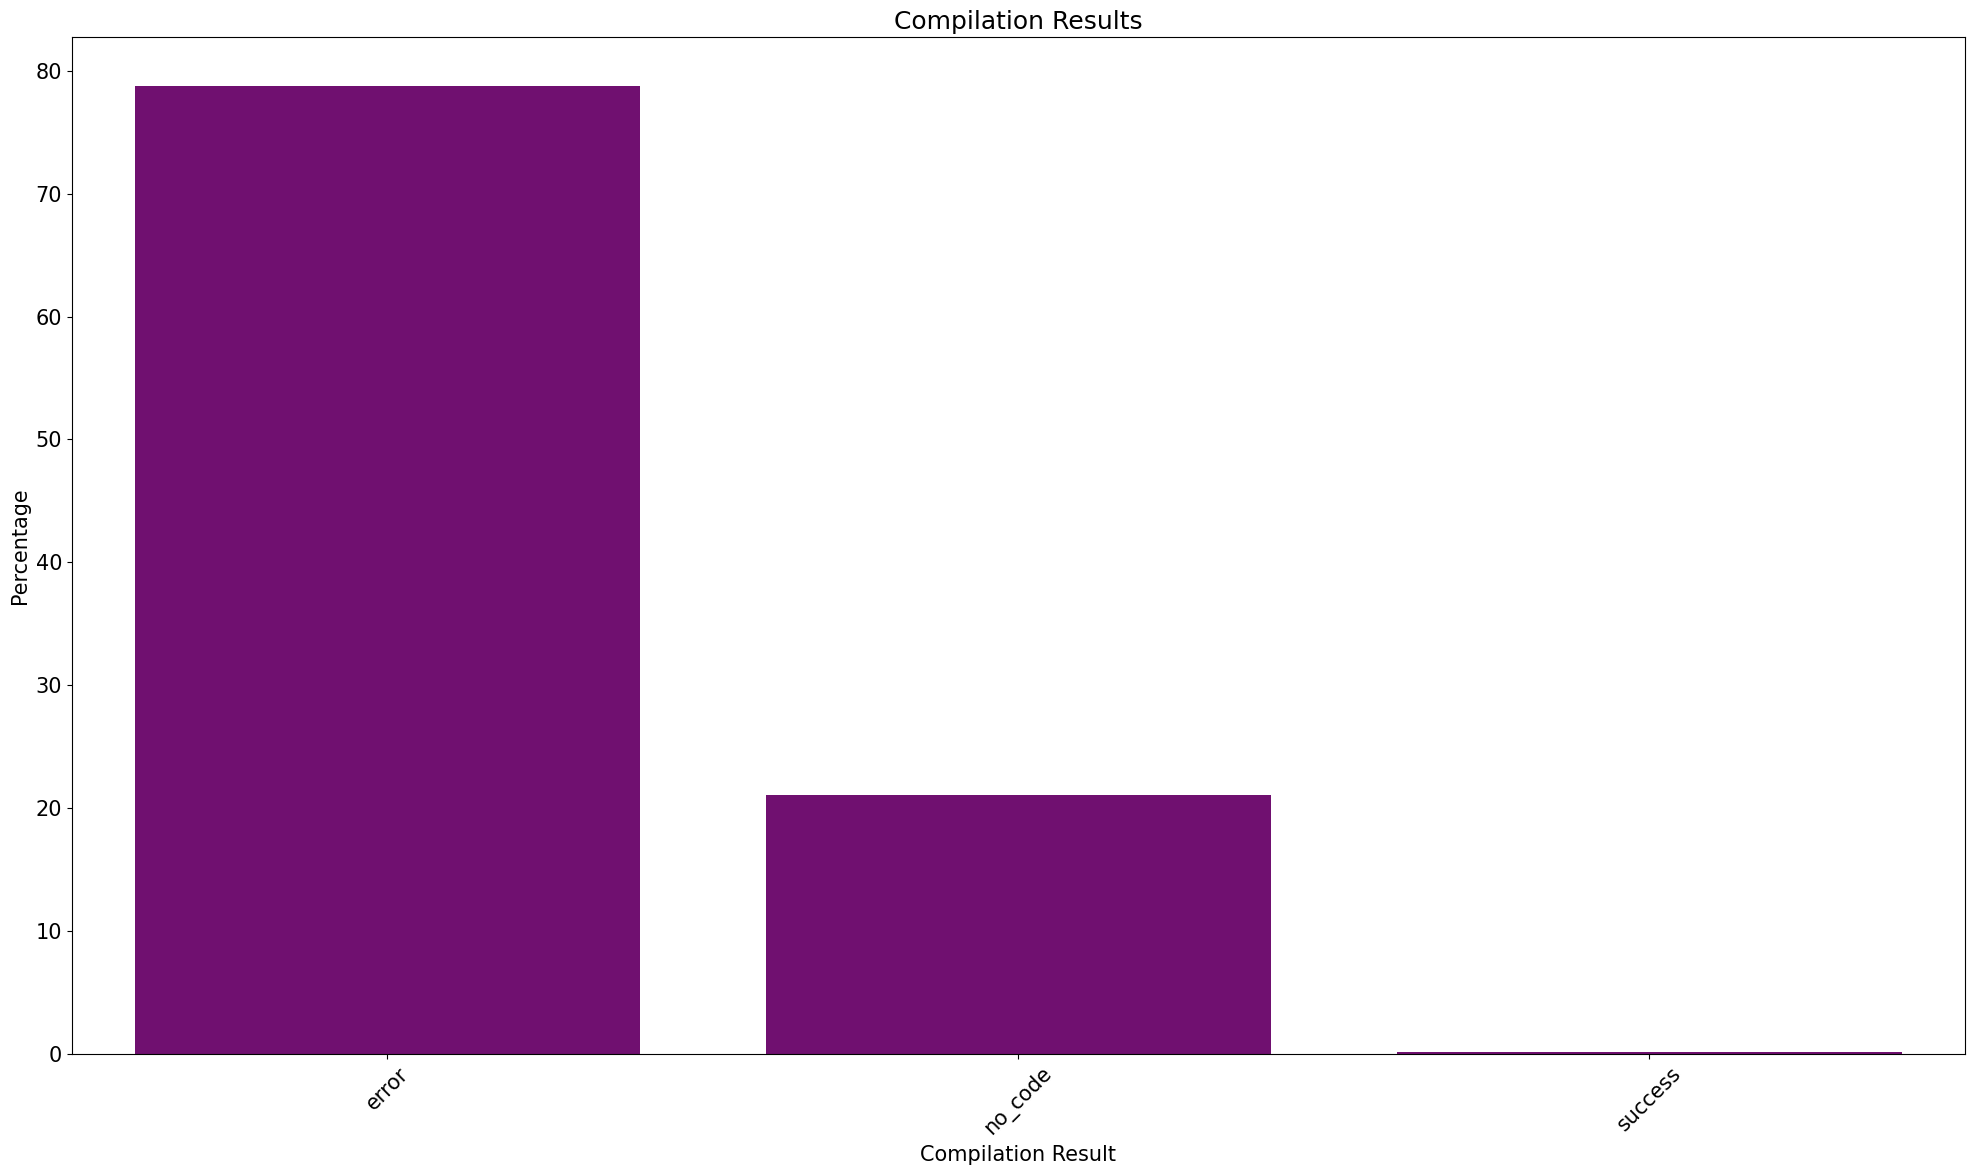

In [9]:
# create statistics of the compilation results
df['compilation_result'] = df['compilation_result'].apply(lambda x: 'error' if 'error' in x.lower() else x)
df['compilation_result'] = df['compilation_result'].str.replace('Compilation successful', 'success')
df['compilation_result'] = df['compilation_result'].str.replace('No code found', 'no_code')

# group per compilation result
df_grouped = df.groupby('compilation_result').size().reset_index(name='count')
df_grouped['percentage'] = df_grouped['count'] / df_grouped['count'].sum() * 100

# visualize using bar chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 12))
sns.barplot(x='compilation_result', y='percentage', data=df_grouped, color="purple")
plt.title('Compilation Results')
plt.xlabel('Compilation Result')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

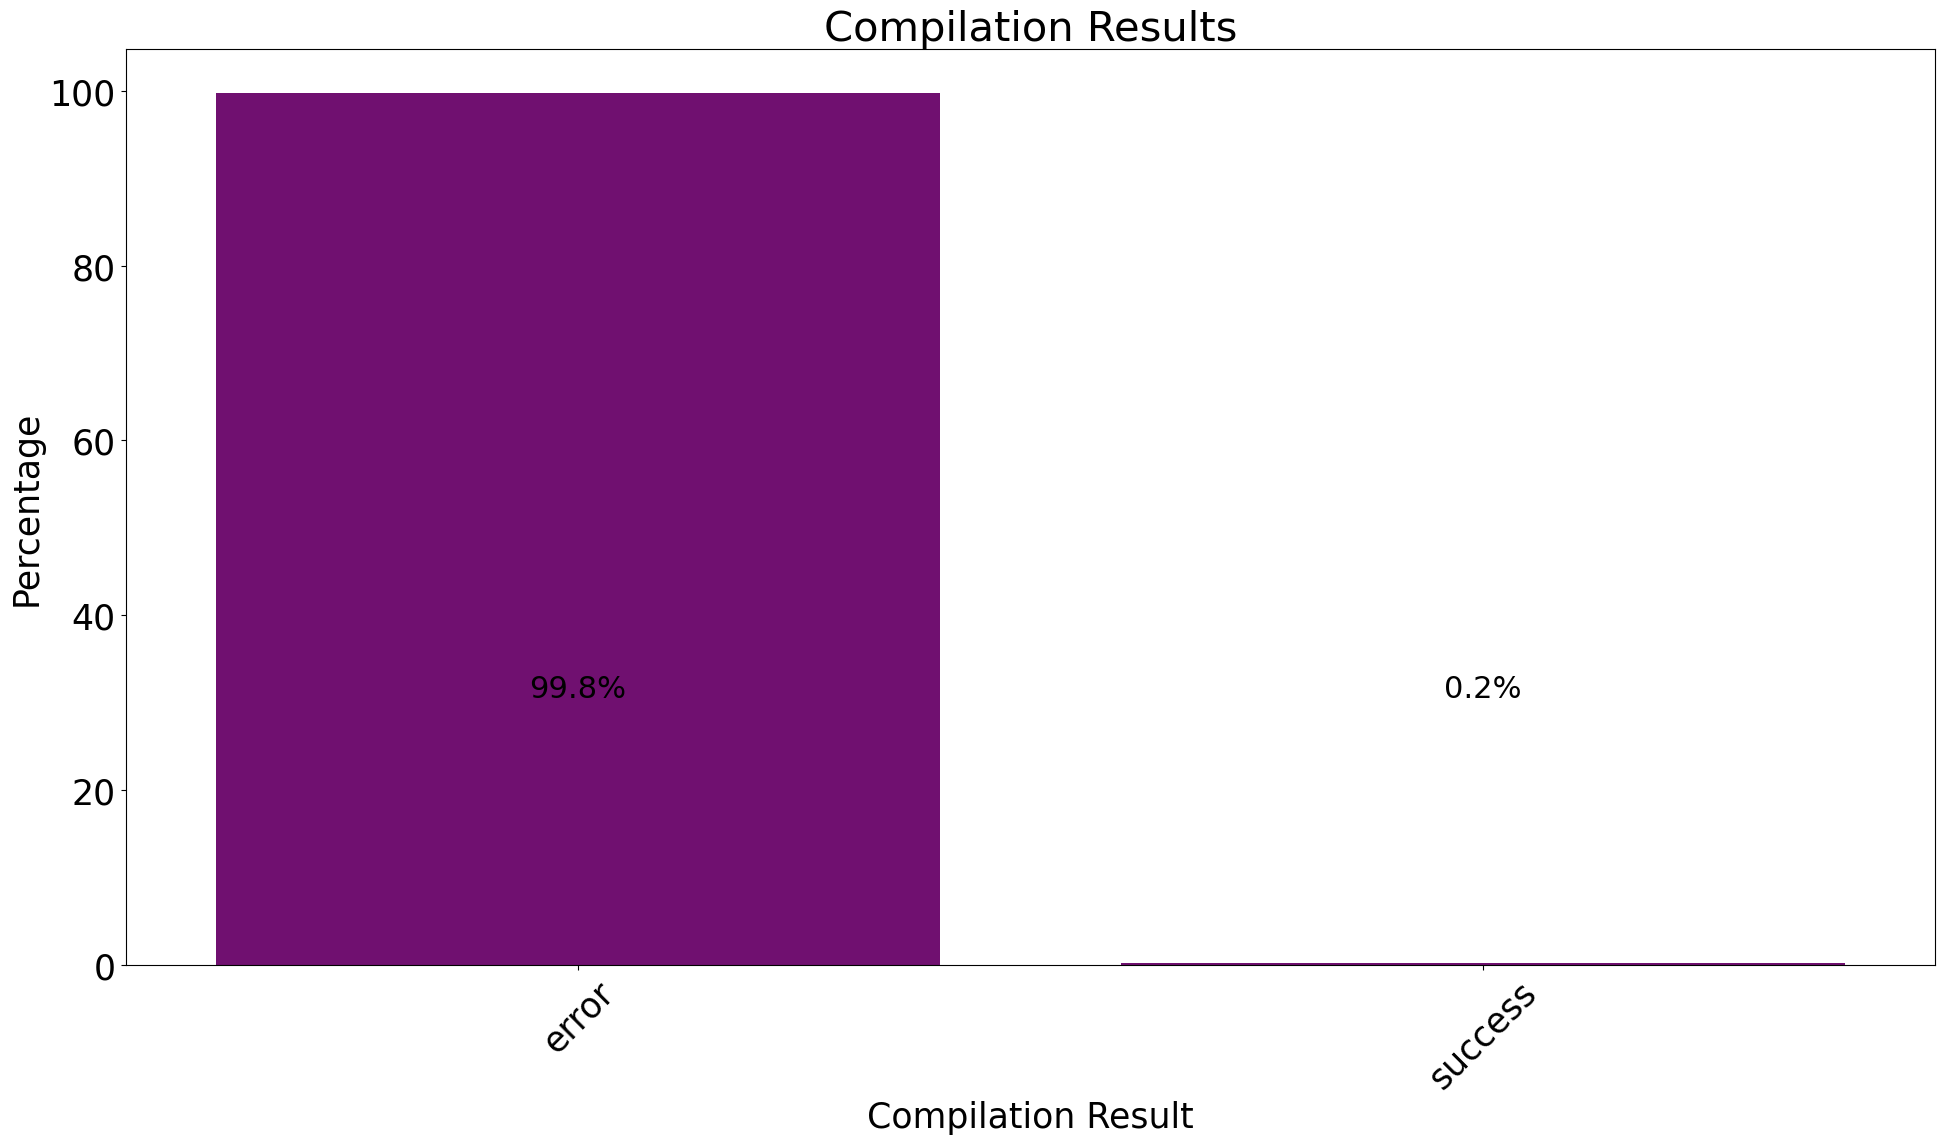

In [10]:
# group per compilation result
df_grouped = df.groupby('compilation_result').size().reset_index(name='count')
# remove the no_code rows
df_grouped = df_grouped[df_grouped['compilation_result'] != 'no_code']
df_grouped['percentage'] = df_grouped['count'] / df_grouped['count'].sum() * 100

# visualize using bar chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20, 12))
ax = sns.barplot(x='compilation_result', y='percentage', data=df_grouped, color="purple")

# Add values on top of bars
ax.text(0, 30, f"{df_grouped['percentage'][0]:.1f}%", ha='center', va='bottom', fontsize=22)
ax.text(1, 30, f"{df_grouped['percentage'][2]:.1f}%", ha='center', va='bottom', fontsize=22)

plt.title('Compilation Results')
plt.xlabel('Compilation Result')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

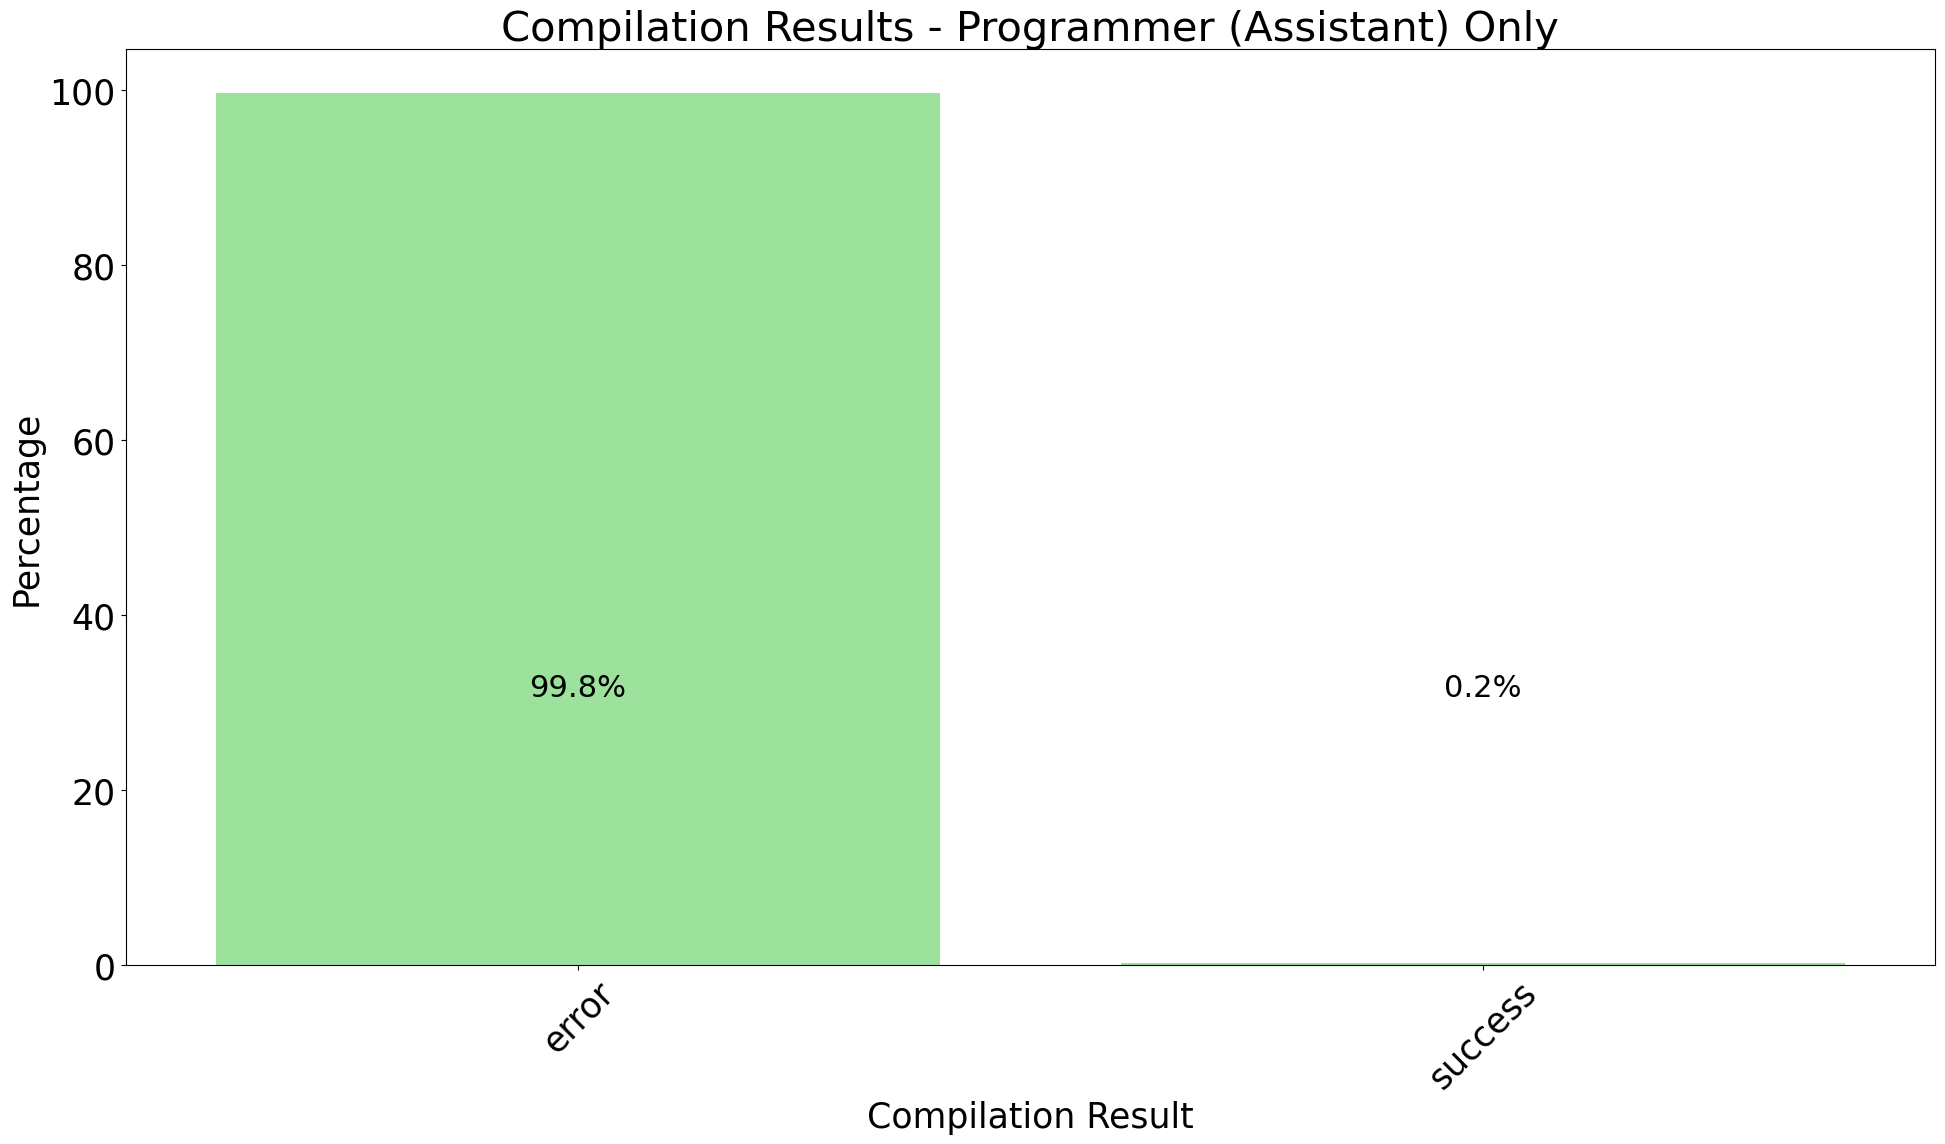

In [11]:
# Filter for only assistant (programmer) rows first
df_assistant = df[df['role'] == 'assistant']

# group per compilation result for assistant rows only
df_grouped = df_assistant.groupby('compilation_result').size().reset_index(name='count')
# remove the no_code rows
df_grouped = df_grouped[df_grouped['compilation_result'] != 'no_code']
df_grouped['percentage'] = df_grouped['count'] / df_grouped['count'].sum() * 100

# visualize using bar chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20, 12))
ax = sns.barplot(x='compilation_result', y='percentage', data=df_grouped, color="lightgreen")

# Add values on top of bars - dynamically position them
# Add values on top of bars
ax.text(0, 30, f"{df_grouped['percentage'][0]:.1f}%", ha='center', va='bottom', fontsize=22)
ax.text(1, 30, f"{df_grouped['percentage'][2]:.1f}%", ha='center', va='bottom', fontsize=22)

plt.title('Compilation Results - Programmer (Assistant) Only')
plt.xlabel('Compilation Result')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# for each of the row, calculate BLUE score to the previous one
def calculate_bleu_score(reference, candidate):
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    smoothing = SmoothingFunction().method1
    return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothing)

programmer_bleu = []

for i in range(1, len(assistant_rows)):
    reference = assistant_rows[i-1]
    candidate = assistant_rows[i]
    try:
        bleu_score = calculate_bleu_score(reference, candidate)
    except:
        bleu_score = 0
    programmer_bleu.append(bleu_score)

In [13]:
# number of rows in the DataFrame
num_rows = len(df)
print(f"Number of rows in the DataFrame: {num_rows}")

# number of unique values in the 'content' column
num_unique_content = df['content'].nunique()
print(f"Number of unique values in the 'content' column: {num_unique_content}")

# number of unique values in the 'code' column
num_unique_code = df['code'].nunique()
print(f"Number of unique values in the 'code' column: {num_unique_code}")

Number of rows in the DataFrame: 2003
Number of unique values in the 'content' column: 1997
Number of unique values in the 'code' column: 1553


In [14]:
# calculate the unique values in the assistant rows
num_unique_assistant = len(set(assistant_rows))
print(f"Number of unique values in the assistant rows: {num_unique_assistant}")

Number of unique values in the assistant rows: 1000


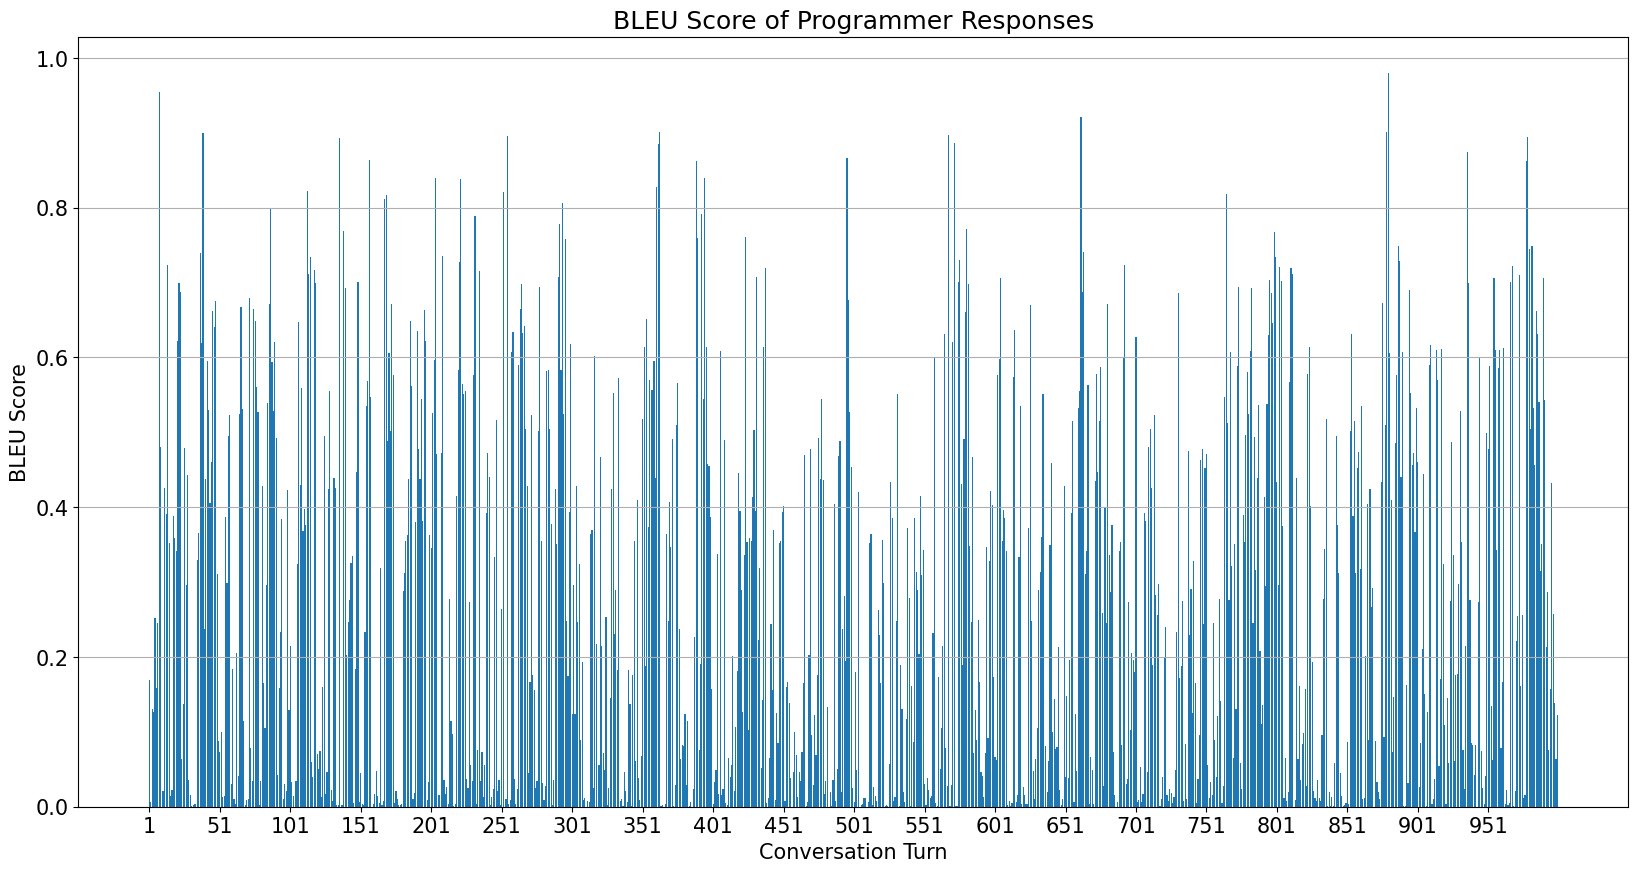

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(20, 10))
plt.bar(range(len(programmer_bleu)), programmer_bleu)
plt.xlabel('Conversation Turn')
plt.ylabel('BLEU Score')
plt.title('BLEU Score of Programmer Responses')
tick_positions = list(range(0, len(programmer_bleu), 50))
tick_labels = [str(i+1) for i in tick_positions]
plt.xticks(tick_positions, tick_labels)
plt.grid(axis='y')

plt.show()

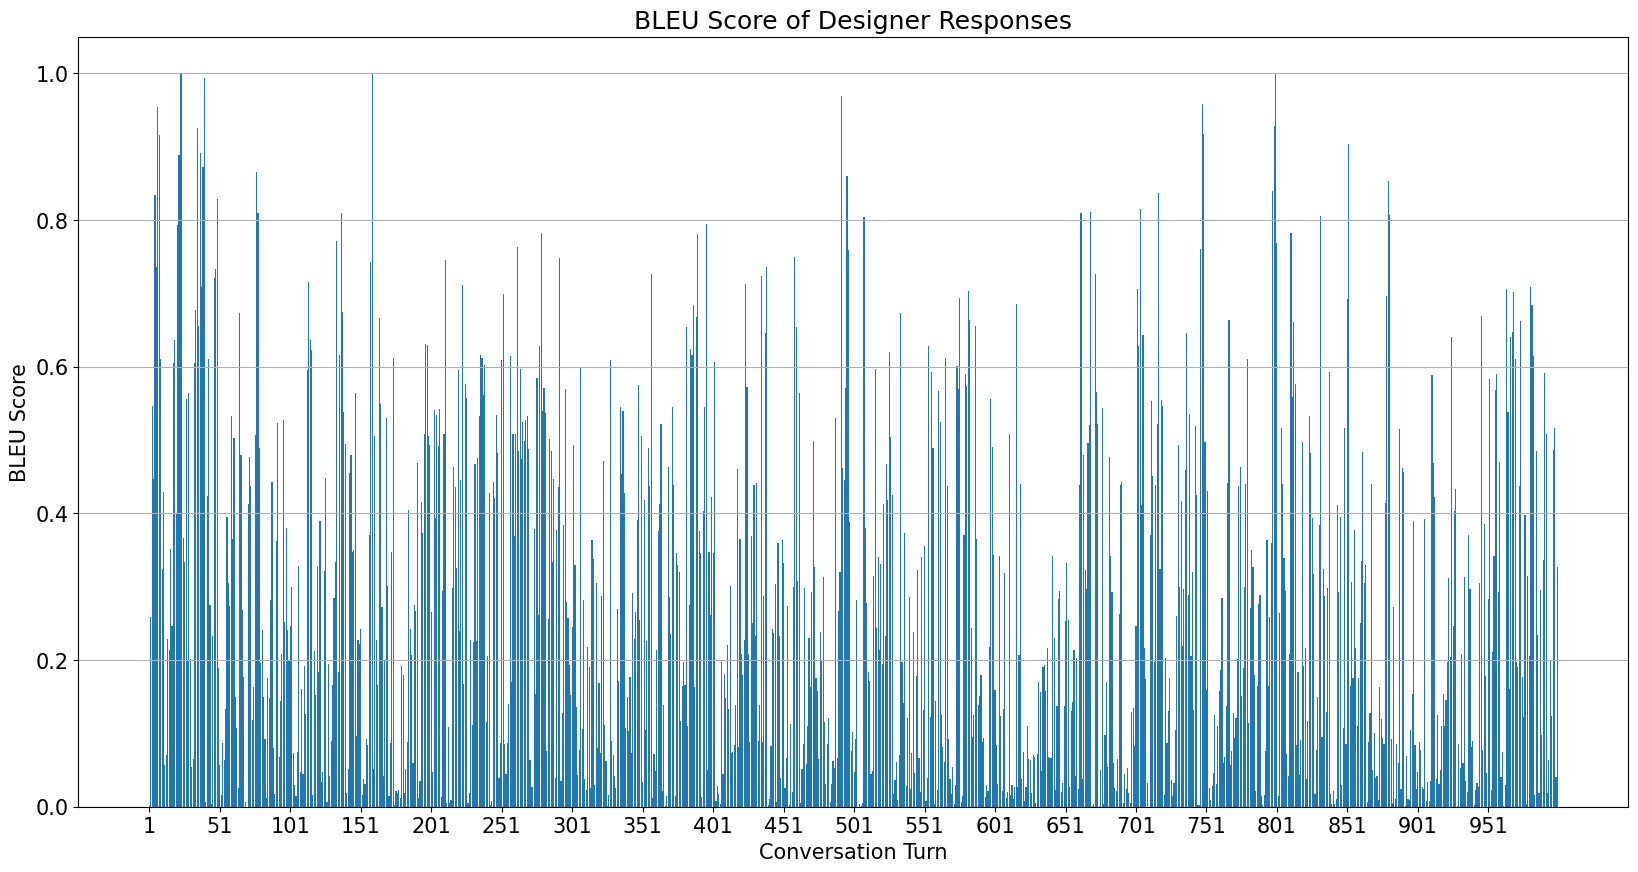

In [16]:
# now do the same for rows with role "user"
# remove rows that contain only "*" in the content column
user_rows = df[df['role'] == 'user']
user_rows = user_rows[['content']].reset_index(drop=True)
user_rows = user_rows['content'].tolist()

len(user_rows)

# for each of the row, calculate BLUE score to the previous one
designer_bleu = []
for i in range(1, len(user_rows)):
    reference = user_rows[i-1]
    candidate = user_rows[i]
    try:
        designer_bleu_one = calculate_bleu_score(reference, candidate)
    except:
        designer_bleu_one = 1
    designer_bleu.append(designer_bleu_one)

plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(20, 10))
plt.bar(range(len(designer_bleu)), designer_bleu)
plt.xlabel('Conversation Turn')
plt.ylabel('BLEU Score')
plt.title('BLEU Score of Designer Responses')
tick_positions = list(range(0, len(designer_bleu), 50))
tick_labels = [str(i+1) for i in tick_positions]
plt.xticks(tick_positions, tick_labels)
plt.grid(axis='y')
plt.show()

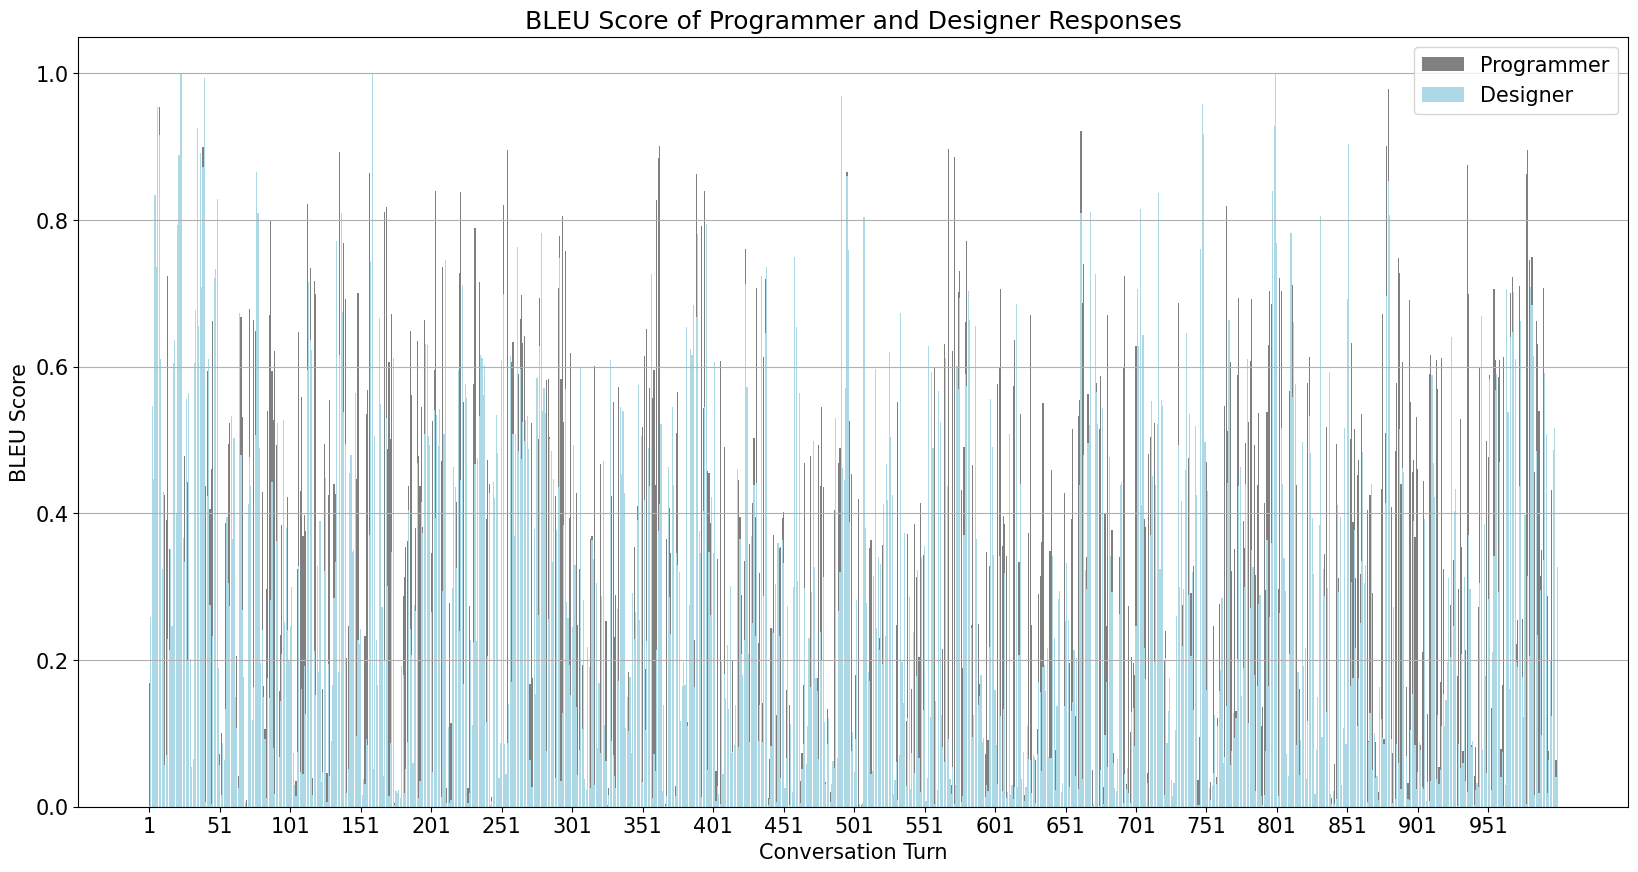

In [17]:
# now merge these two diagrams, with the programmer in blue and the designer in red
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 10))
plt.bar(range(len(programmer_bleu)), programmer_bleu, color='grey', label='Programmer')
plt.bar(range(len(designer_bleu)), designer_bleu, color='lightblue', label='Designer')
plt.xlabel('Conversation Turn')
plt.ylabel('BLEU Score')
plt.title('BLEU Score of Programmer and Designer Responses')
tick_positions = list(range(0, max(len(programmer_bleu), len(designer_bleu)), 50))
tick_labels = [str(i+1) for i in tick_positions]
plt.xticks(tick_positions, tick_labels)
plt.grid(axis='y')
plt.legend()

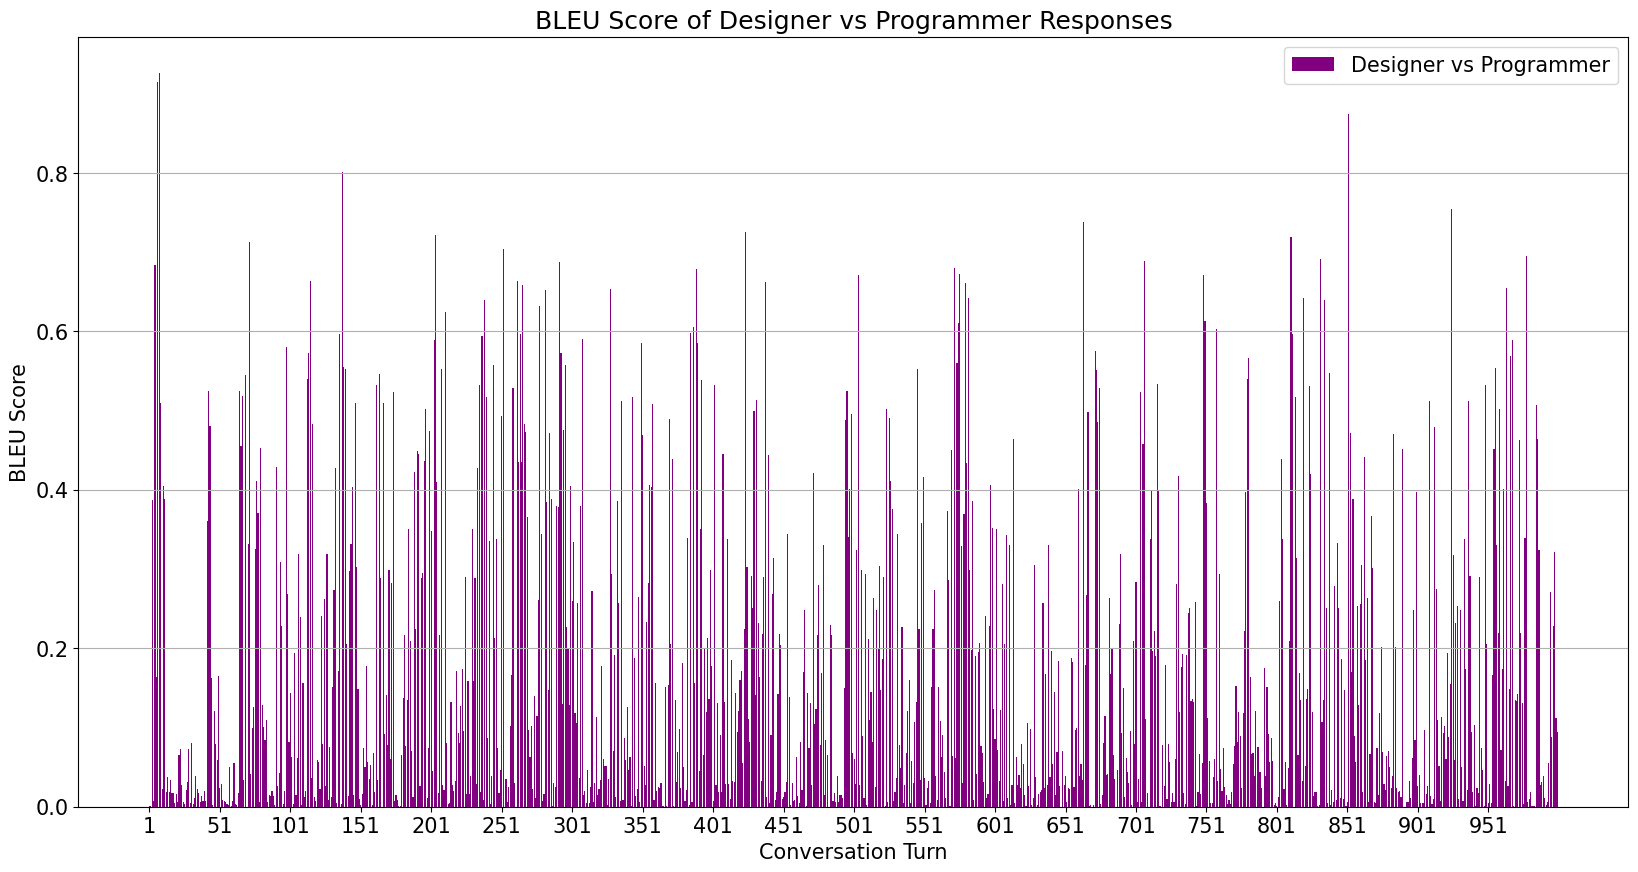

In [18]:
# now I want to calculate the BLUE score between the two roles
bleu_scores = []
for i in range(1, min(len(user_rows),len(assistant_rows))):
    reference = user_rows[i-1]
    candidate = assistant_rows[i]
    try:
        bleu_score = calculate_bleu_score(reference, candidate)
    except:
        bleu_score = 1
    bleu_scores.append(bleu_score)
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 10))
plt.bar(range(len(bleu_scores)), bleu_scores, color='purple', label='Designer vs Programmer')
plt.xlabel('Conversation Turn')
plt.ylabel('BLEU Score')
plt.title('BLEU Score of Designer vs Programmer Responses')
tick_positions = list(range(0, len(bleu_scores), 50))
tick_labels = [str(i+1) for i in tick_positions]
plt.xticks(tick_positions, tick_labels)
plt.grid(axis='y')
plt.legend()
plt.show()

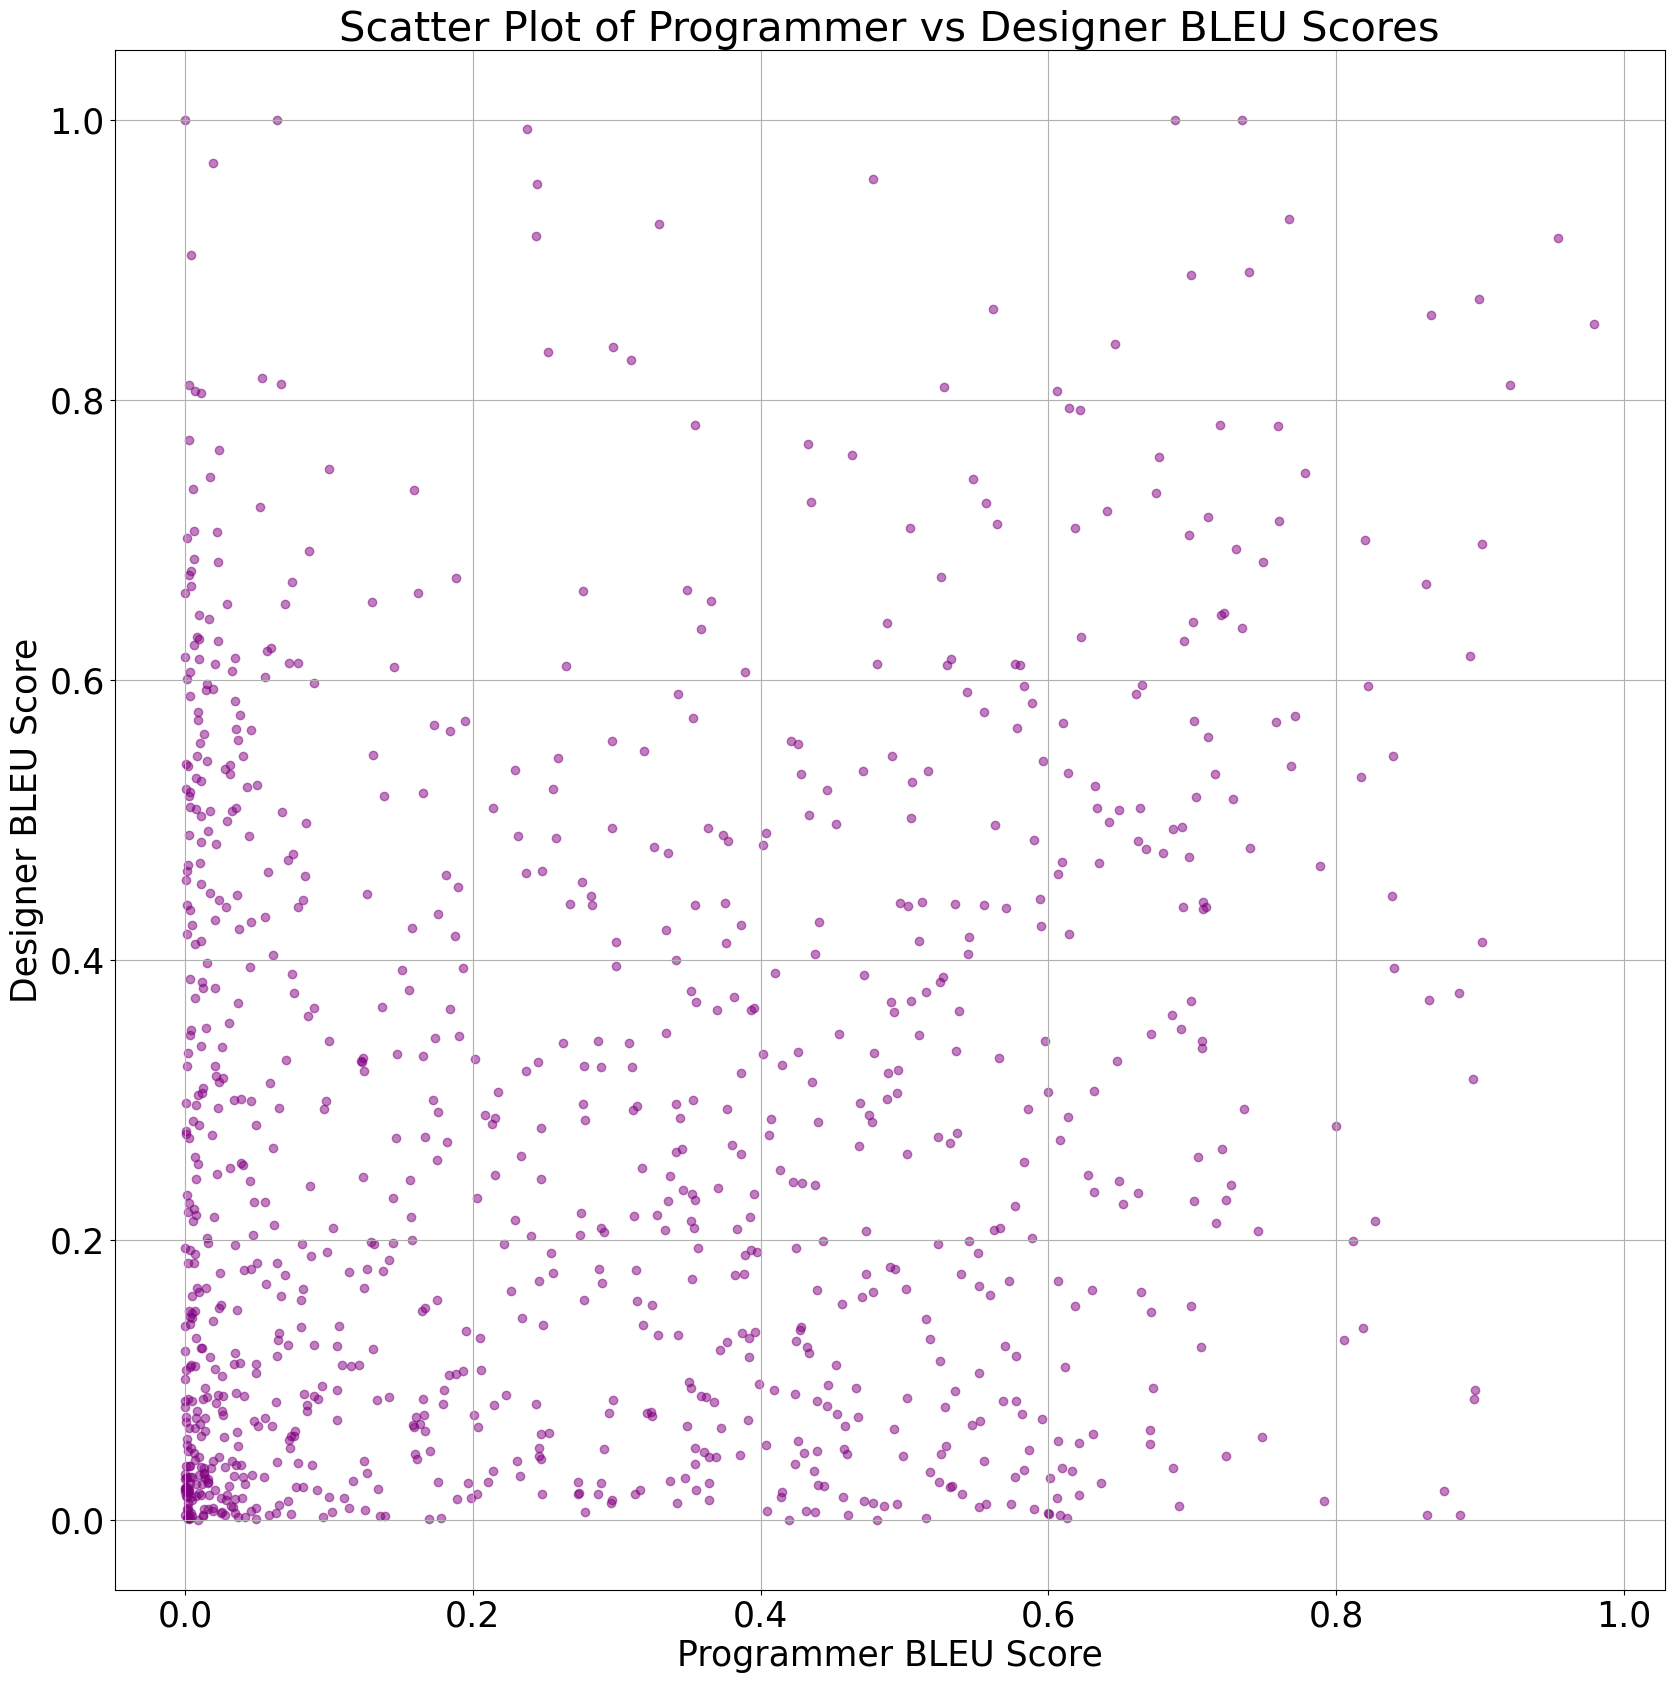

In [19]:
# Calculate BLEU scores for programmer (assistant) responses
programmer_bleu = []
for i in range(1, len(assistant_rows)):
    reference = assistant_rows[i-1]
    candidate = assistant_rows[i]
    try:
        score = calculate_bleu_score(reference, candidate)
    except: 
        score = 1
    programmer_bleu.append(score)

# Calculate BLEU scores for designer (user) responses
designer_bleu = []
for i in range(1, len(user_rows)):
    reference = user_rows[i-1]
    candidate = user_rows[i]
    try:
        score = calculate_bleu_score(reference, candidate)
    except: 
        score = 1
    designer_bleu.append(score)

# Trim to the minimum length to ensure alignment
min_len = min(len(programmer_bleu), len(designer_bleu))
programmer_bleu = programmer_bleu[:min_len]
designer_bleu = designer_bleu[:min_len]

# Create scatter plot: Programmer on x-axis, Designer on y-axis
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20, 20))
plt.scatter(programmer_bleu, designer_bleu, color='purple', alpha=0.5)
plt.xlabel('Programmer BLEU Score')
plt.ylabel('Designer BLEU Score')
plt.title('Scatter Plot of Programmer vs Designer BLEU Scores')
plt.grid(True)
plt.show()

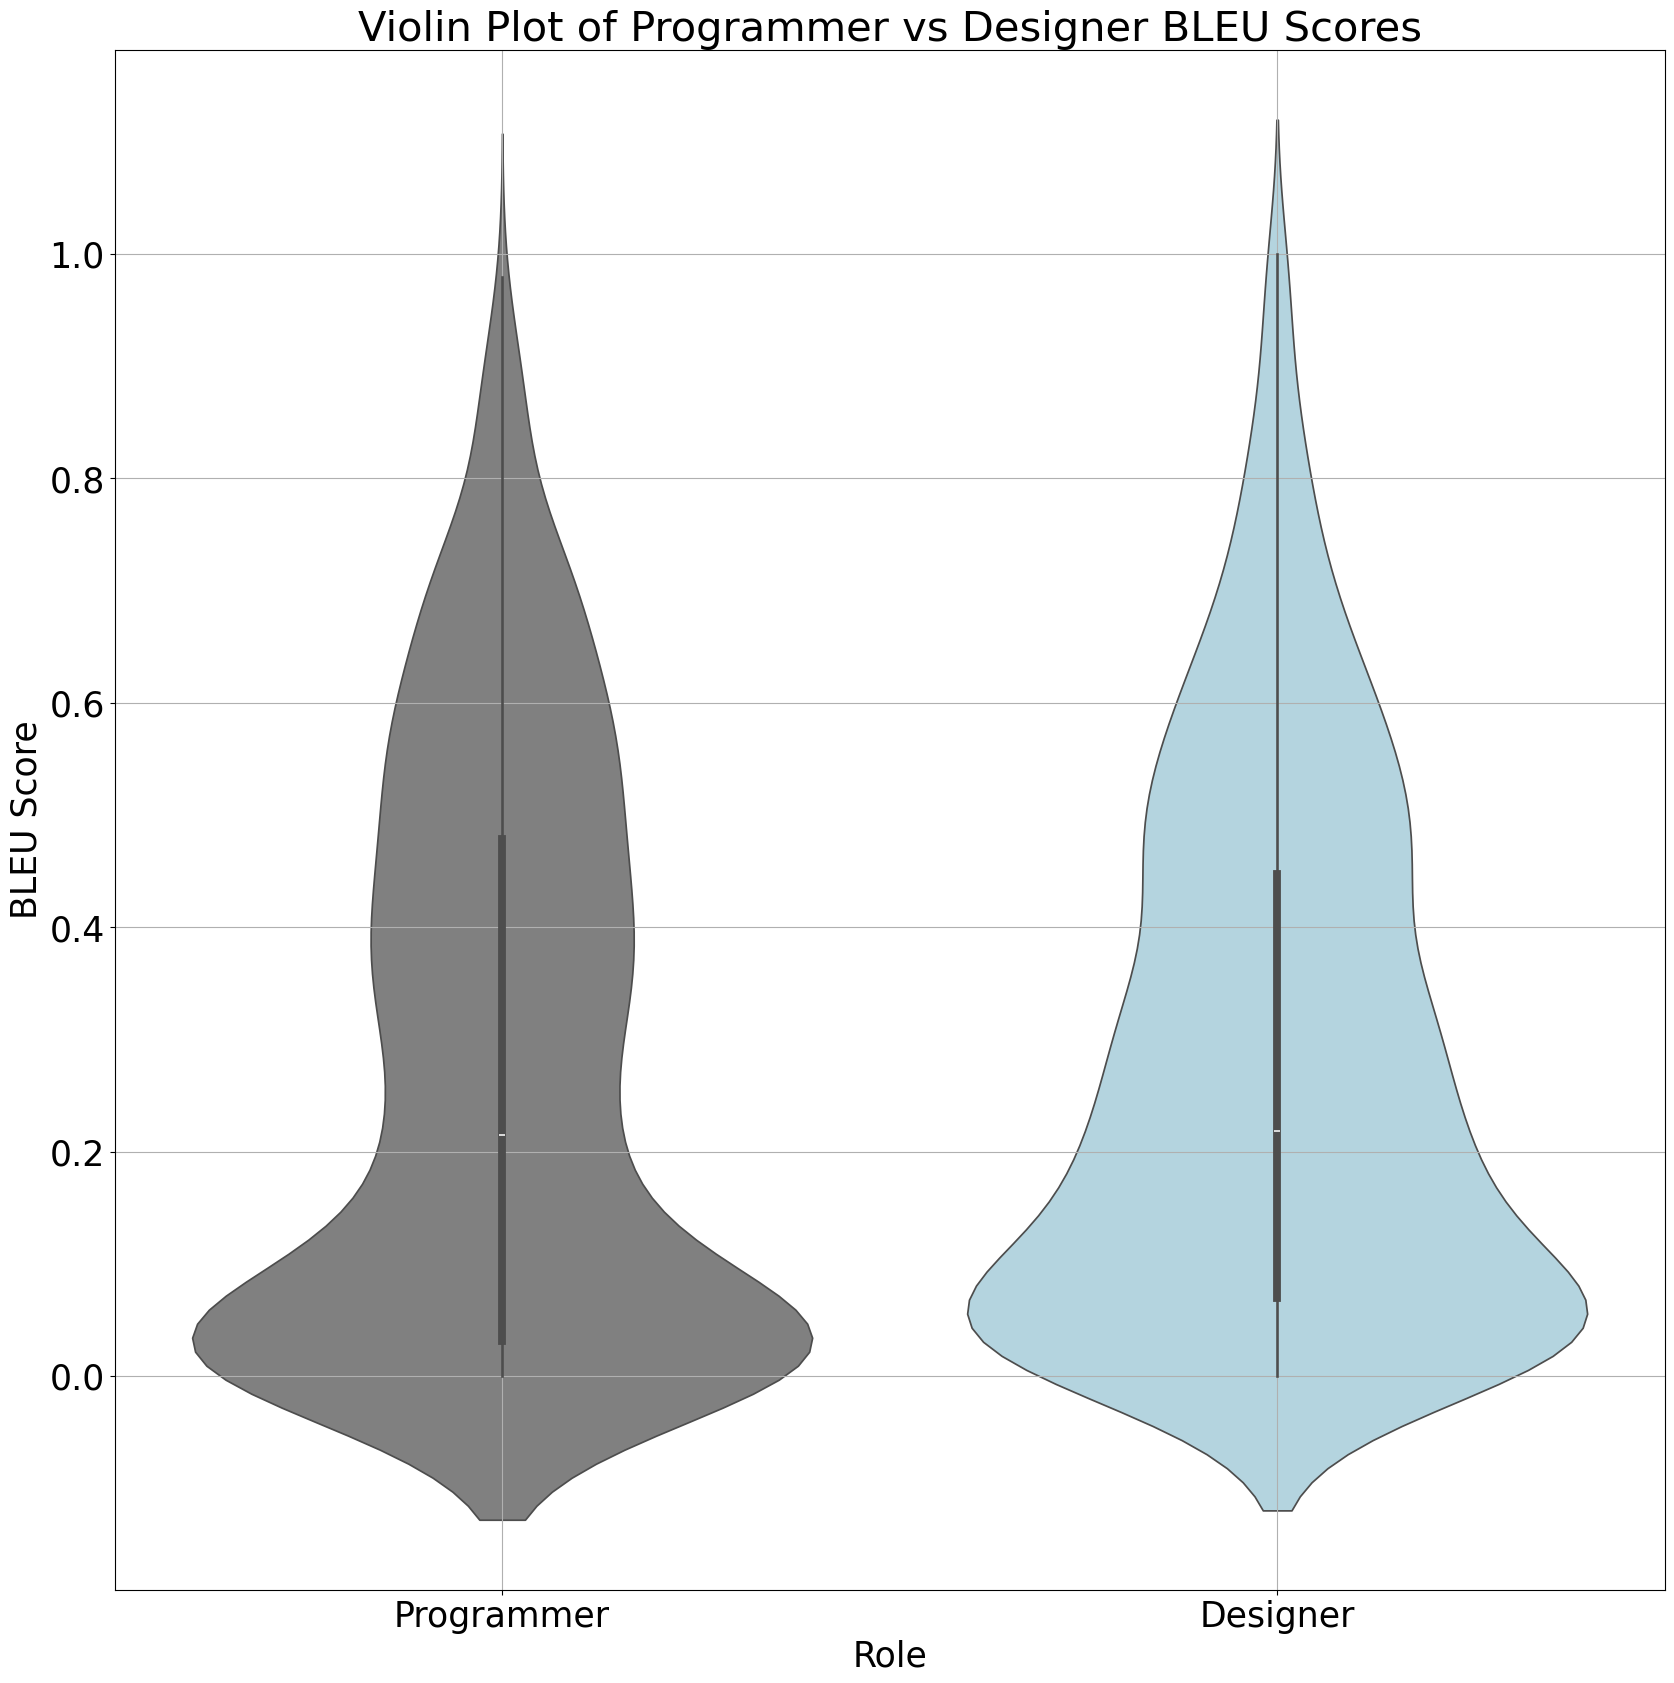

In [20]:
# now I want a violin plot of the two distributions
import seaborn as sns
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20, 20))
sns.violinplot(data=[programmer_bleu, designer_bleu], palette=['grey', 'lightblue'])
plt.xticks([0, 1], ['Programmer', 'Designer'])
plt.xlabel('Role')
plt.ylabel('BLEU Score')
plt.title('Violin Plot of Programmer vs Designer BLEU Scores')
plt.grid(True)
plt.show()

In [21]:
# now I want to calculate the number of words in each response
def count_words(text):
    try: 
        result = len(text.split())
    except:
        result = 0
    return result
programmer_word_counts = [count_words(response) for response in assistant_rows]
designer_word_counts = [count_words(response) for response in user_rows]

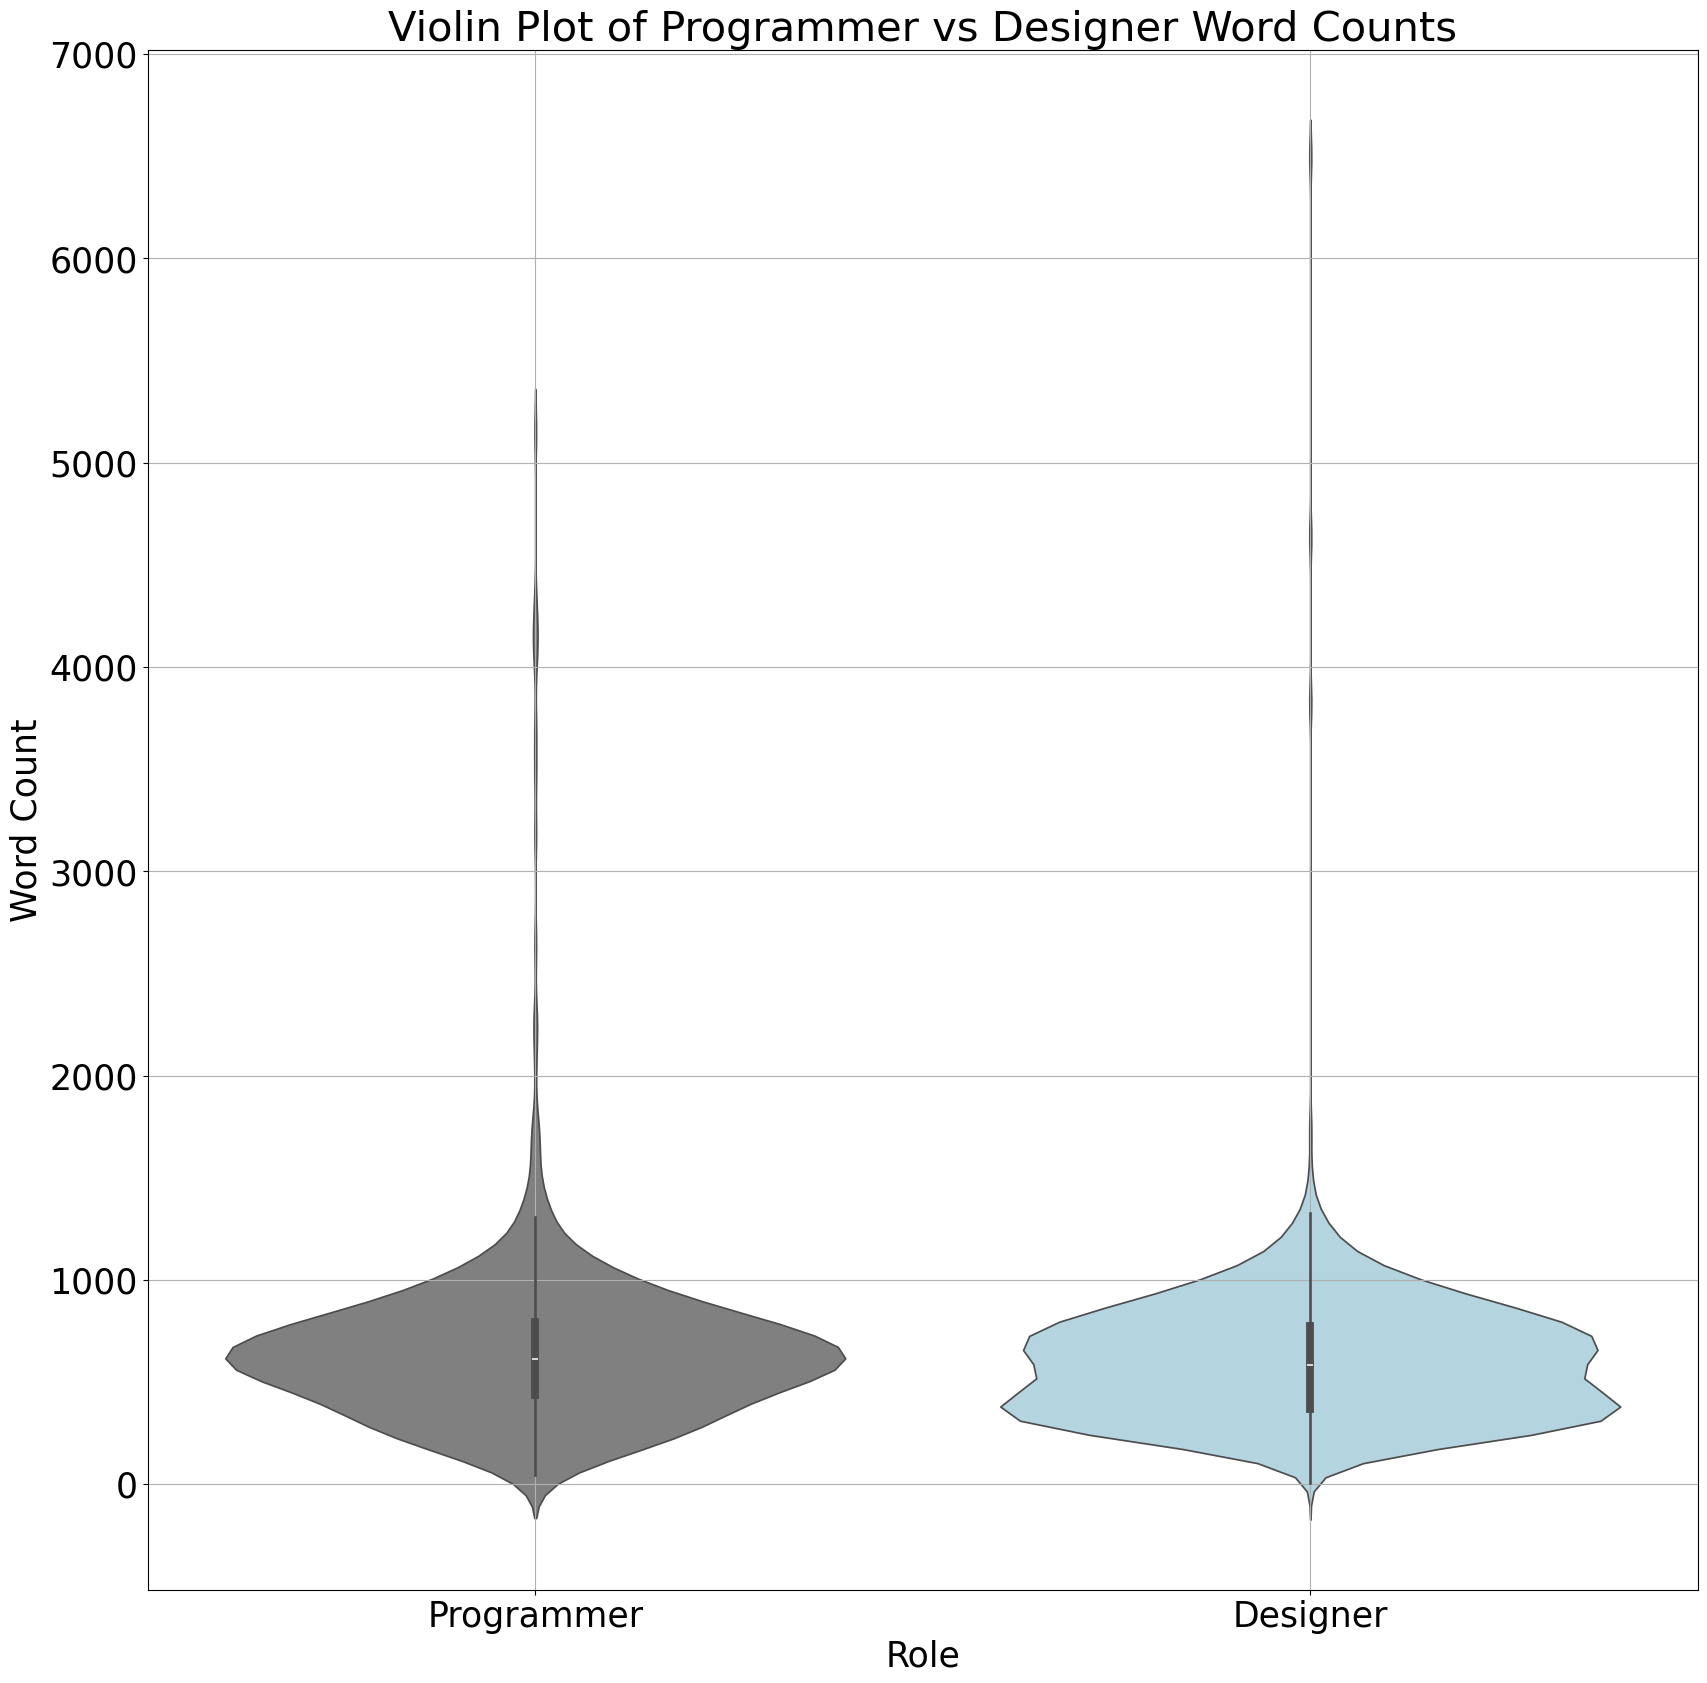

In [22]:
# now plot this as violin plots
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20, 20))
sns.violinplot(data=[programmer_word_counts, designer_word_counts], palette=['grey', 'lightblue'])
plt.xticks([0, 1], ['Programmer', 'Designer'])
plt.xlabel('Role')
plt.ylabel('Word Count')
plt.title('Violin Plot of Programmer vs Designer Word Counts')
plt.grid(True)
plt.show()

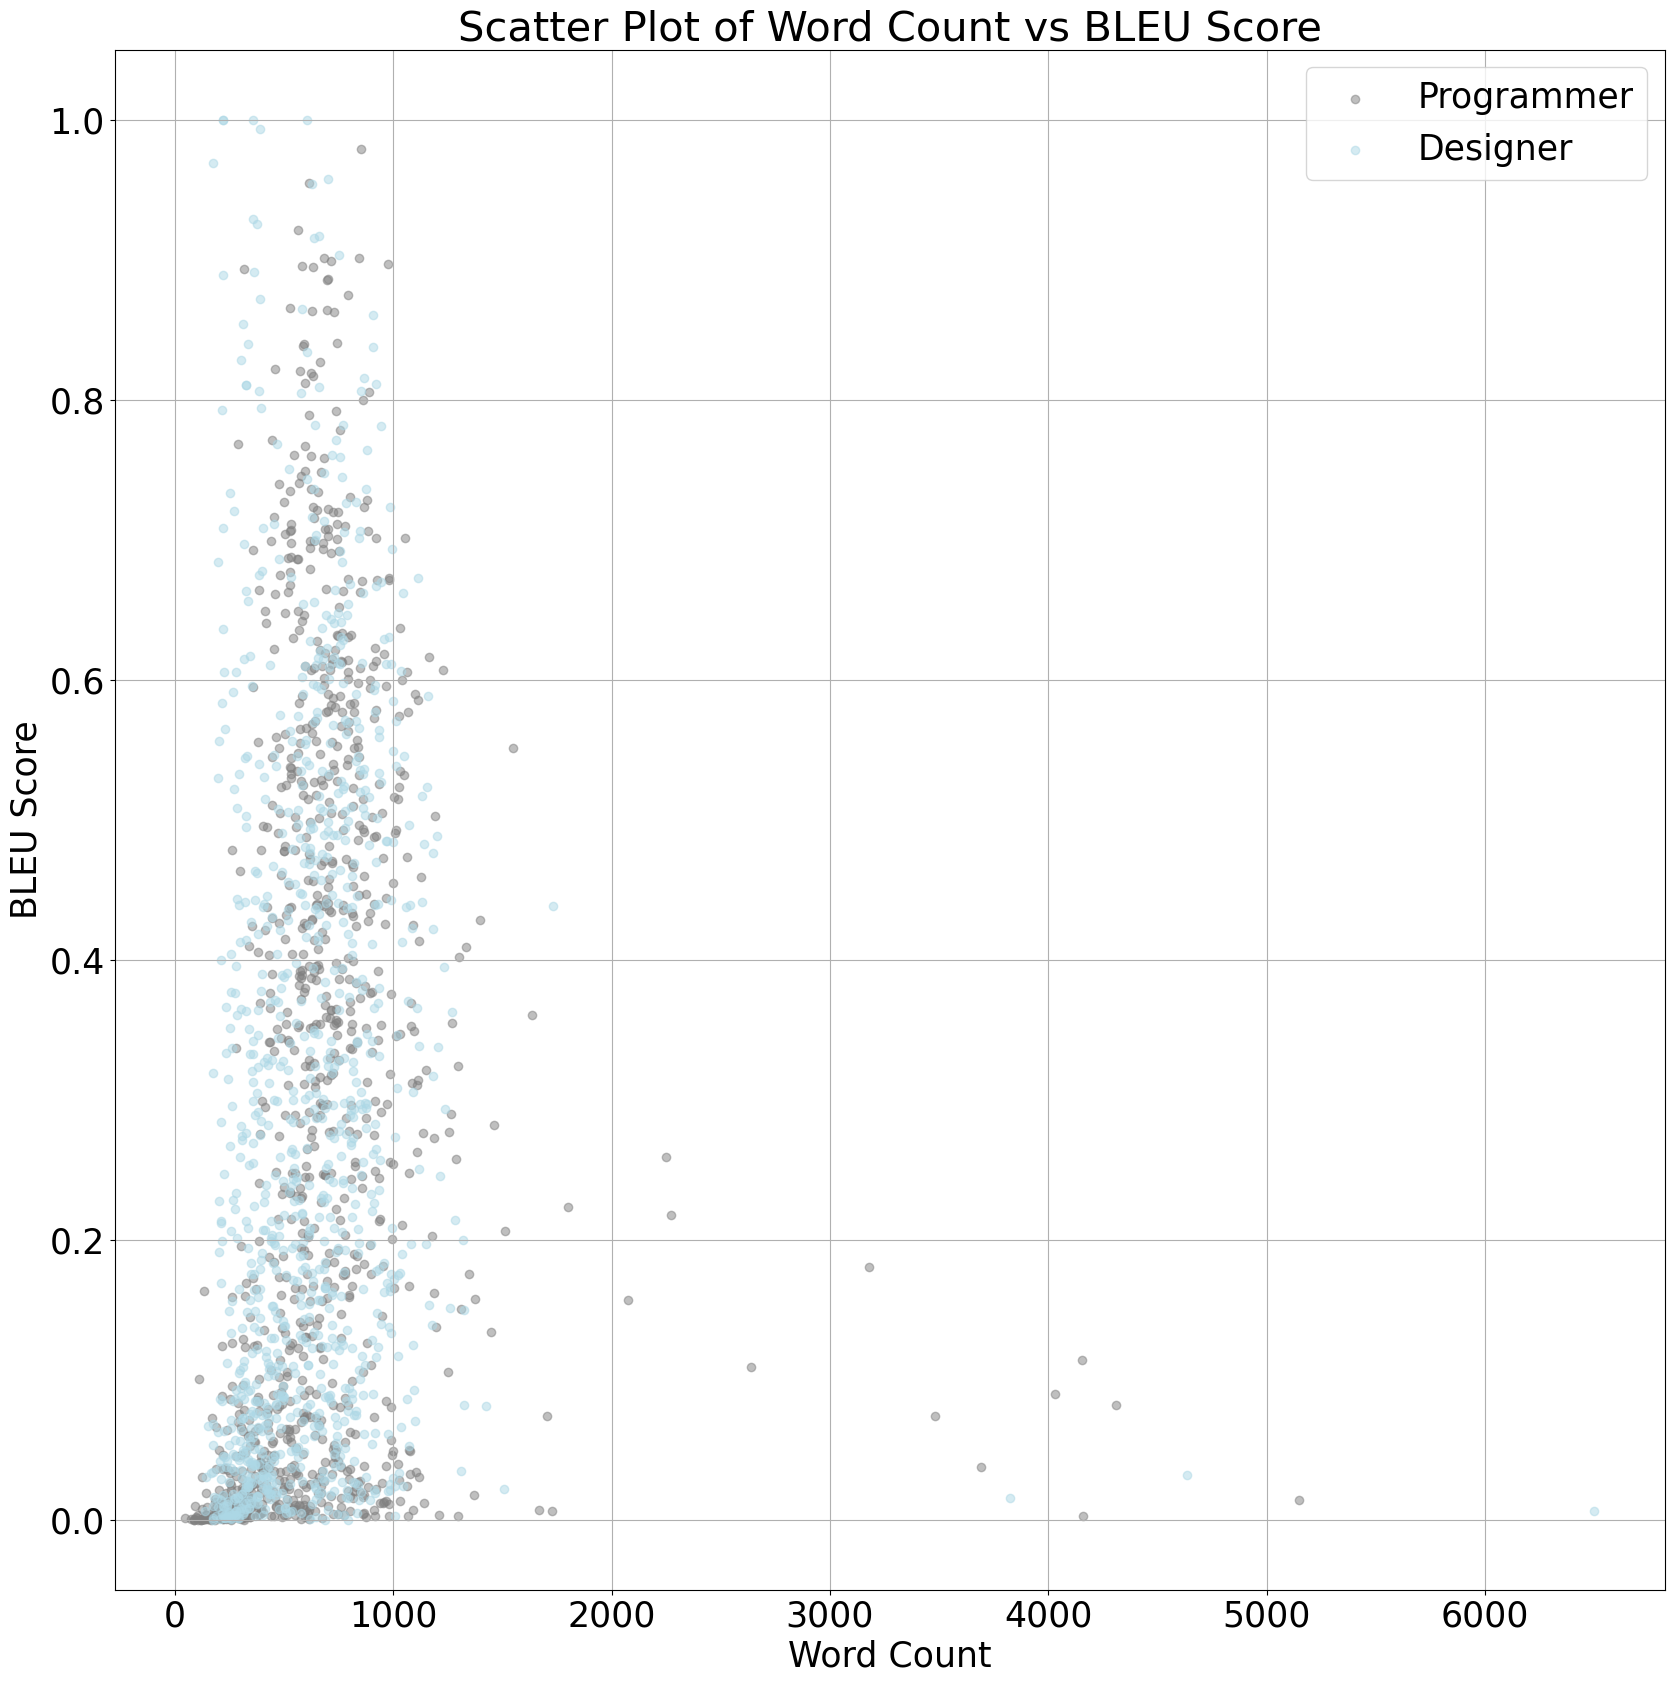

In [23]:
# now I want the scatter plot between the number of words and the BLUE score
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20, 20))
plt.scatter(programmer_word_counts[1:min(len(assistant_rows),len(user_rows))], programmer_bleu, color='grey', label='Programmer', alpha=0.5)
plt.scatter(designer_word_counts[1:min(len(assistant_rows),len(user_rows))], designer_bleu, color='lightblue', label='Designer', alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('BLEU Score')
plt.title('Scatter Plot of Word Count vs BLEU Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# now do all that for ROUGE score
def calculate_rouge_score(reference, candidate):
    from rouge import Rouge
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference)
    return scores[0]['rouge-l']['f']

# Calculate ROUGE scores for programmer (assistant) responses
programmer_rouge = []
for i in range(1, len(assistant_rows)):
    reference = assistant_rows[i-1]
    candidate = assistant_rows[i]
    try:
        score = calculate_rouge_score(reference, candidate)
    except:
        score = 1
    programmer_rouge.append(score)

# Calculate ROUGE scores for designer (user) responses
designer_rouge = []
for i in range(1, len(user_rows)):
    reference = user_rows[i-1]
    candidate = user_rows[i]
    try:
        score = calculate_rouge_score(reference, candidate)
    except:
        score = 1
    designer_rouge.append(score)

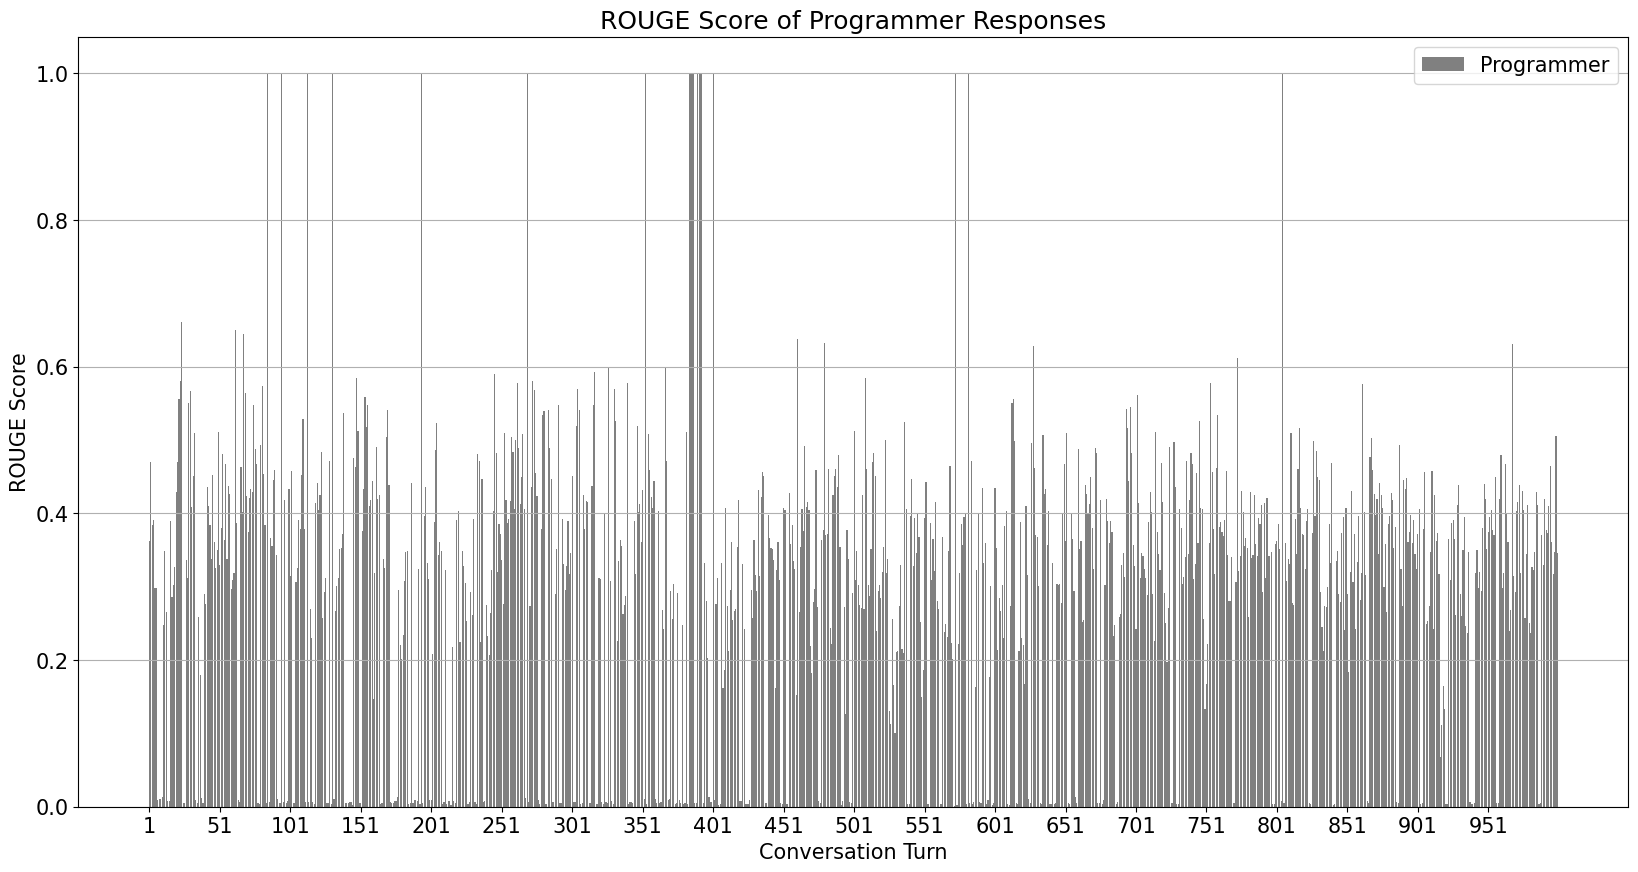

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 10))
plt.bar(range(len(programmer_rouge)), programmer_rouge, color='grey', label='Programmer')
plt.xlabel('Conversation Turn')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Score of Programmer Responses')
tick_positions = list(range(0, len(designer_rouge), 50))
tick_labels = [str(i+1) for i in tick_positions]
plt.xticks(tick_positions, tick_labels)
plt.grid(axis='y')
plt.legend()
plt.show()

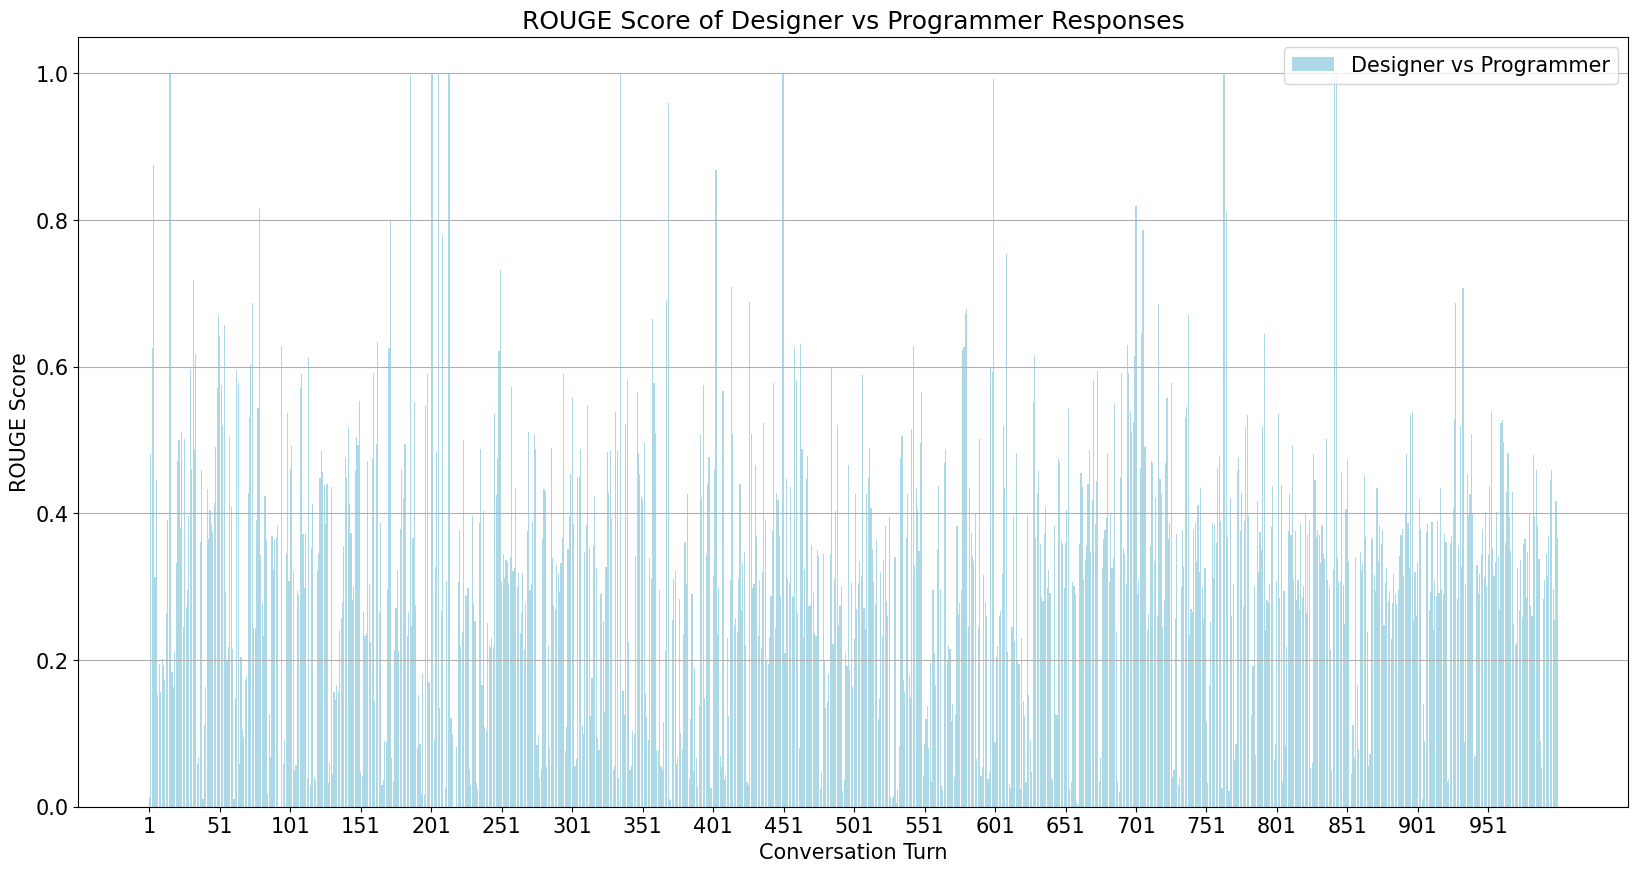

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 10))
plt.bar(range(len(designer_rouge)), designer_rouge, color='lightblue', label='Designer vs Programmer')
plt.xlabel('Conversation Turn')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Score of Designer vs Programmer Responses')
tick_positions = list(range(0, len(designer_rouge), 50))
tick_labels = [str(i+1) for i in tick_positions]
plt.xticks(tick_positions, tick_labels)
plt.grid(axis='y')
plt.legend()
plt.show()

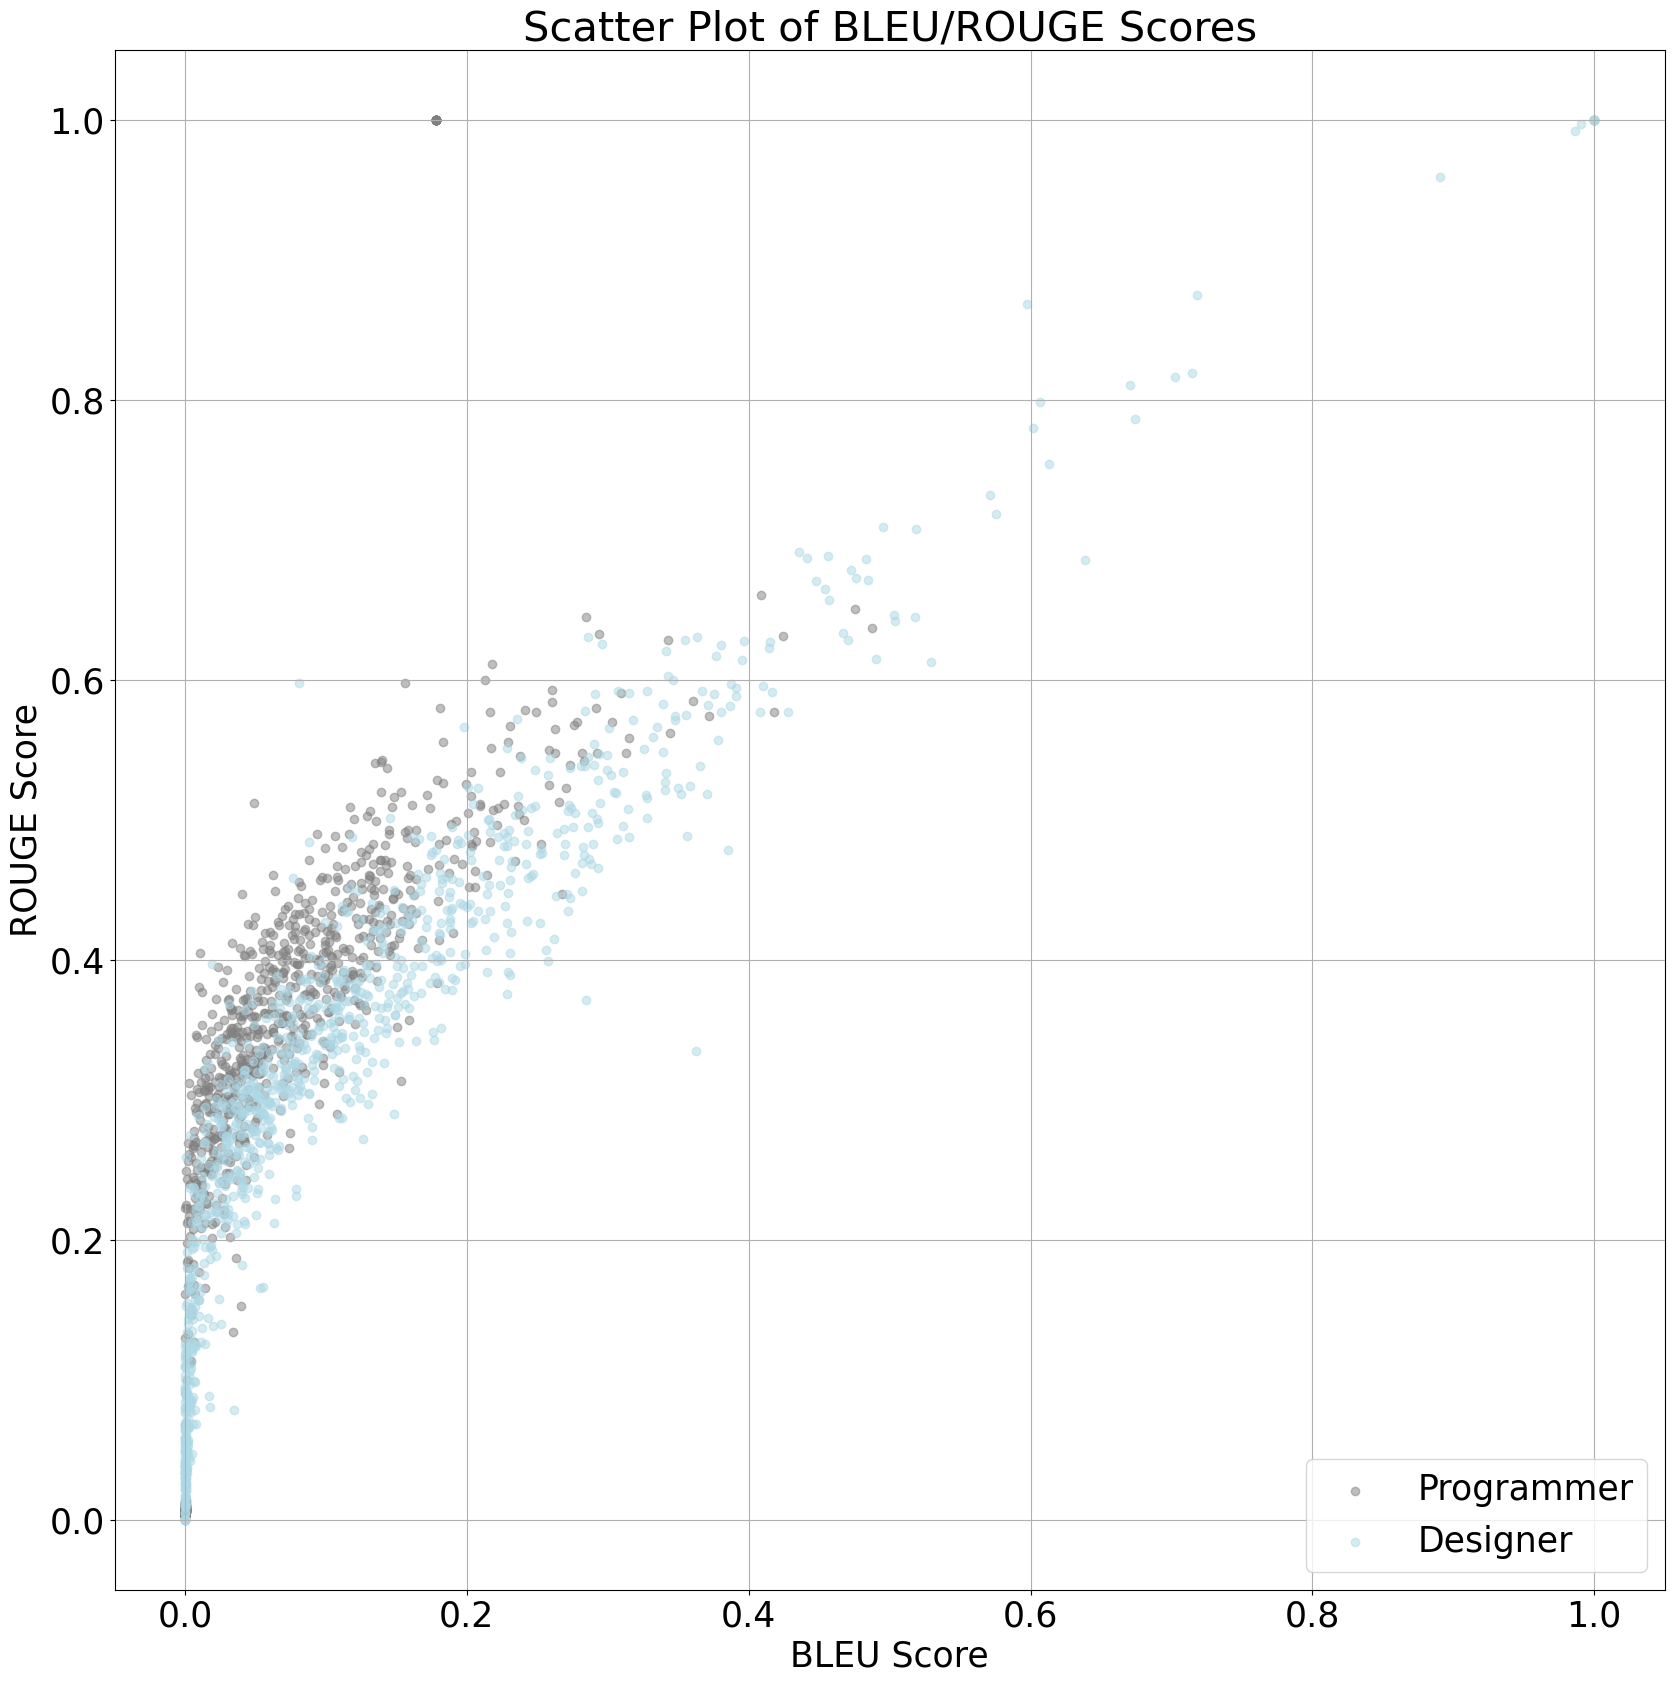

In [ ]:
# visualize scatter plot for BLUE and ROUGE scores
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20, 20))
plt.scatter(programmer_bleu[0:min(len(programmer_bleu), len(designer_bleu))], programmer_rouge[0:min(len(programmer_rouge), len(designer_rouge))], color='grey', alpha=0.5, label='Programmer')
plt.scatter(designer_bleu[0:min(len(programmer_bleu), len(designer_bleu))], designer_rouge[0:min(len(programmer_rouge), len(designer_rouge))], color='lightblue', alpha=0.5, label='Designer')
plt.xlabel('BLEU Score')
plt.ylabel('ROUGE Score')
plt.title('Scatter Plot of BLEU/ROUGE Scores')
plt.legend()
plt.grid(True)
plt.show()